# xRV Analysis

## Notebook Contents

- [Imports](#Imports)
- [Data](#Data)
- [Preprocessing](#Preprocessing)
- [Analysis](#Analysis)
    - [Run Value by Event](#Run-Value-for-Ball-in-Play-by-Events)
    - [Run Value by Count](#Run-Value-by-Count)
    - [Avg Run Value by Pitch Type](#Average-Run-Value-by-Pitch-Type)
- [Fastball](#Fastball-Analysis)
    - [Fastball Metrics](#Fastball-Metrics)
    - [Top Fastball xRV](#Top-Fastballs-by-xRV)
    - [RHP Fastball xRV Break Plot](#RHP-Fastball-Break-Plot-by-xRV)
    - [LHP Fastball xRV Break Plot](#LHP-Fastball-Break-Plot-by-xRV)
- [Breaking Ball Analysis](#Breaking-Ball-Analysis)
    - [Breaking Ball Metrics](#Breaking-Ball-Metrics)
    - [Top Breaking Ball xRV](#Top-Breaking-Balls-by-xRV)
    - [RHP Breaking Ball xRV Break Plot](#RHP-Breaking-Ball-Break-Plot-by-xRV)
    - [LHP Breaking Ball xRV Break Plot](#LHP-Breaking-Ball-Break-Plot-by-xRV)
- [Off-Speed Analysis](#Off-Speed-Analysis)
    - [Off-Speed Metrics](#Off-Speed-Metrics)
    - [Top Off-Speed xRV](#Top-Off-Speeds-by-xRV)
    - [RHP Off-Speed xRV Break Plot](#RHP-Off-Speed-Break-Plot-by-xRV)
    - [LHP Off-Speed xRV Break Plot](#LHP-Off-Speed-Break-Plot-by-xRV)

# Imports

In [1]:
from sklearn.preprocessing import scale, StandardScaler
from matplotlib.patches import Rectangle
from statsmodels.stats.outliers_influence import variance_inflation_factor

import warnings
warnings.filterwarnings('ignore')

# Data

In [2]:
data = pd.read_csv('../data/model-pitches-rv.csv', index_col = [0])
data.drop(columns = ['plate_x', 'release_pos_x'], inplace = True)
data.rename(columns = {'pfx_-x': 'pfx_x', 
                       'plate_-x': 'plate_x', 
                       'release_pos_-x': 'release_pos_x'}, 
            inplace = True)

rv_table = pd.read_csv('../data/rv_table.csv', index_col = [0])

xrv_grouped = pd.read_csv('../data/xrv_grouped.csv', index_col = [0])
pd.set_option('max_columns', None)
print(xrv_grouped.shape)
xrv_grouped.head()

(705434, 14)


,player_name,p_throws,pitch_type,velo,pfx_x,pfx_z,release_pos_x,release_pos_z,release_extension,rv,n_pitches,xRV,RV/100,xRV/100
0,"Gsellman, Robert",R,SI,94.3,16.20,10.56,1.20,6.05,6.5,-0.110,1,-0.070286,-11.0,-7.03
1,"Gsellman, Robert",R,SI,94.3,18.24,5.88,1.29,6.02,6.4,-0.047,1,-0.035488,-4.7,-3.55
2,"Gsellman, Robert",R,SI,94.2,17.04,6.36,1.41,5.88,6.4,-0.034,1,-0.054566,-3.4,-5.46
3,"Gsellman, Robert",R,SI,94.1,15.36,4.32,1.31,5.96,6.4,-0.135,1,-0.004550,-13.5,-0.45
4,"Gsellman, Robert",R,SI,93.6,15.48,6.96,1.42,5.89,6.5,-0.135,1,-0.108406,-13.5,-10.84


In [3]:
print(rv_table.shape)
rv_table.head()

(3469, 14)


,player_name,p_throws,pitch_type,n_pitches,velo,pfx_x,pfx_z,release_pos_x,release_pos_z,release_extension,rv,xRV,RV/100,xRV/100
0,"Abbott, Cory",R,FF,207,92.6,9.6,17.2,2.6,5.5,6.2,5.7,1.4,2.7,0.7
1,"Abreu, Albert",R,FF,103,97.8,11.7,15.4,2.5,5.7,6.4,-1.5,-1.9,-1.5,-1.9
2,"Abreu, Albert",R,SI,212,98.0,15.3,13.3,2.5,5.6,6.5,1.0,0.3,0.4,0.2
3,"Abreu, Bryan",R,FF,310,95.7,8.0,17.1,1.5,6.0,6.3,-1.4,-1.5,-0.4,-0.5
4,"Abreu, Bryan",R,SI,2,96.0,14.2,14.9,1.9,5.9,6.4,-0.0,0.0,-1.2,1.6


# Preprocessing

In [4]:
rhp_fb = xrv_grouped[xrv_grouped['pitch_type'].isin(['FF', 'SI']) & (xrv_grouped['p_throws'] == 'R')]
lhp_fb = xrv_grouped[xrv_grouped['pitch_type'].isin(['FF', 'SI']) & (xrv_grouped['p_throws'] == 'L')]
fb = xrv_grouped[xrv_grouped['pitch_type'].isin(['FF', 'SI'])]
rhp_bb = xrv_grouped[xrv_grouped['pitch_type'].isin(['SL', 'FC', 'CU', 'KC']) & (xrv_grouped['p_throws'] == 'R')]
lhp_bb = xrv_grouped[xrv_grouped['pitch_type'].isin(['SL', 'FC', 'CU', 'KC']) & (xrv_grouped['p_throws'] == 'L')]
bb = xrv_grouped[xrv_grouped['pitch_type'].isin(['SL', 'FC', 'CU', 'KC'])]
rhp_os = xrv_grouped[xrv_grouped['pitch_type'].isin(['CH', 'FS']) & (xrv_grouped['p_throws'] == 'R')]
lhp_os = xrv_grouped[xrv_grouped['pitch_type'].isin(['CH', 'FS']) & (xrv_grouped['p_throws'] == 'L')]
os = xrv_grouped[xrv_grouped['pitch_type'].isin(['CH', 'FS'])]

fb_rvtable = rv_table[rv_table['pitch_type'].isin(['FF', 'SI'])]
bb_rvtable = rv_table[rv_table['pitch_type'].isin(['SL', 'FC', 'CU', 'KC'])]
os_rvtable = rv_table[rv_table['pitch_type'].isin(['CH', 'FS'])]

# Analysis

### Run Value for Ball in Play by Events

In [5]:
data.groupby(['events'], as_index = False)['lin_weight_above_outs', 'lin_weights_above_outs_scale', 'rv'].mean()

,events,lin_weight_above_outs,lin_weights_above_outs_scale,rv
0,double,1.041,1.259,0.770134
1,field_error,0.716,0.866,0.445453
2,field_out,0.000,0.000,-0.271401
3,game_advisory,0.194,0.235,-0.060667
4,hit_by_pitch,0.630,0.762,0.359255
5,home_run,1.657,2.003,1.385794
6,single,0.746,0.902,0.474625
7,triple,1.334,1.613,1.062984
8,walk,0.603,0.729,0.332287


### Run Value by Count

In [6]:
data.groupby(['pitch_count'], as_index = False)['woba', 'wraa_change', 'rv'].mean()

,pitch_count,woba,wraa_change,rv
0,0-0,0.314,-0.009612,0.002206
1,0-1,0.265,-0.018634,-0.003365
2,0-2,0.197,-0.067630,-0.067365
3,1-0,0.356,-0.008224,0.006870
4,1-1,0.300,-0.021001,0.001974
...,...,...,...,...
8,2-2,0.269,-0.105299,-0.069878
9,3-0,0.540,0.006415,0.096440
10,3-1,0.477,-0.006323,0.083824
11,3-2,0.379,0.011064,0.023962


### Average Run Value by Pitch Type

In [7]:
xrv_grouped.groupby(['pitch_type'], as_index = False, sort = False)['rv', 'RV/100', 
                                                                    'xRV', 'xRV/100'].mean().round(2)

,pitch_type,rv,RV/100,xRV,xRV/100
0,SI,-0.00,-0.21,0.00,0.30
1,FF,-0.01,-0.90,-0.01,-0.52
2,SL,-0.02,-1.84,-0.01,-1.47
3,CU,-0.02,-1.65,-0.01,-1.38
4,FC,-0.01,-0.80,-0.01,-0.60
5,KC,-0.02,-1.92,-0.02,-1.58
6,CH,-0.01,-1.05,-0.01,-0.78
7,FS,-0.03,-2.60,-0.02,-2.06


# Fastball Analysis

### Fastball Metrics

In [8]:
good_rhp_fb = rhp_fb.groupby(['pitch_type', 'p_throws'], as_index = False, 
                                sort = False)['velo', 'pfx_x', 'pfx_z', 'xRV'].mean()
fb_r_pitches = rhp_fb.groupby(['pitch_type', 'p_throws'], as_index = False, sort = False)['n_pitches'].sum()
avg_rhp_fb = pd.merge(good_rhp_fb, fb_r_pitches, how = 'right', on = ['pitch_type', 'p_throws'])


good_lhp_fb = lhp_fb.groupby(['pitch_type', 'p_throws'], as_index = False, 
                                sort = False)['velo', 'pfx_x', 'pfx_z', 'xRV'].mean()
fb_l_pitches = lhp_fb.groupby(['pitch_type', 'p_throws'], as_index = False, sort = False)['n_pitches'].sum()
avg_lhp_fb = pd.merge(good_lhp_fb, fb_l_pitches, how = 'right', on = ['pitch_type', 'p_throws'])

fb_avg = pd.concat([avg_rhp_fb, avg_lhp_fb], ignore_index = True)
fb_avg.insert(2, 'n_pitches', fb_avg.pop('n_pitches'))
fb_avg = fb_avg.round(1)
fb_avg.head()

,pitch_type,p_throws,n_pitches,velo,pfx_x,pfx_z,xRV
0,SI,R,75681,93.4,14.8,9.2,0.0
1,FF,R,176387,94.1,7.1,16.1,-0.0
2,FF,L,73295,92.8,-7.5,16.2,-0.0
3,SI,L,33470,92.1,-15.0,9.3,0.0


### Above Average Fastball Metrics

In [9]:
abv_rhp_fb = rhp_fb.loc[rhp_fb['xRV'] < -.05]
abv_lhp_fb = lhp_fb.loc[lhp_fb['xRV'] < -.05]

great_rhp_fb = abv_rhp_fb.groupby(['pitch_type', 'p_throws'], as_index = False, 
                                sort = False)['velo', 'pfx_x', 'pfx_z', 'xRV'].mean()
fb_r_pitches = abv_rhp_fb.groupby(['pitch_type', 'p_throws'], as_index = False, sort = False)['n_pitches'].sum()
abv_rhp_fb = pd.merge(great_rhp_fb, fb_r_pitches, how = 'right', on = ['pitch_type', 'p_throws'])


great_lhp_fb = abv_lhp_fb.groupby(['pitch_type', 'p_throws'], as_index = False, 
                                sort = False)['velo', 'pfx_x', 'pfx_z', 'xRV'].mean()
fb_l_pitches = abv_lhp_fb.groupby(['pitch_type', 'p_throws'], as_index = False, sort = False)['n_pitches'].sum()
abv_lhp_fb = pd.merge(great_lhp_fb, fb_l_pitches, how = 'right', on = ['pitch_type', 'p_throws'])

fb_abv = pd.concat([abv_rhp_fb, abv_lhp_fb], ignore_index = True)
fb_abv.insert(2, 'n_pitches', fb_abv.pop('n_pitches'))
fb_abv = fb_abv.round(1)
fb_abv.head()

,pitch_type,p_throws,n_pitches,velo,pfx_x,pfx_z,xRV
0,SI,R,15293,93.7,14.9,9.1,-0.1
1,FF,R,39746,94.6,7.2,16.2,-0.1
2,FF,L,16970,93.2,-7.5,16.2,-0.1
3,SI,L,6994,92.5,-15.1,9.3,-0.1


### Below Average Fastball Metrics

In [10]:
blw_rhp_fb = rhp_fb.loc[rhp_fb['xRV'] > .05]
blw_lhp_fb = lhp_fb.loc[lhp_fb['xRV'] > .05]

great_rhp_fb = blw_rhp_fb.groupby(['pitch_type', 'p_throws'], as_index = False, 
                                sort = False)['velo', 'pfx_x', 'pfx_z', 'xRV'].mean()
fb_r_pitches = blw_rhp_fb.groupby(['pitch_type', 'p_throws'], as_index = False, sort = False)['n_pitches'].sum()
blw_rhp_fb = pd.merge(great_rhp_fb, fb_r_pitches, how = 'right', on = ['pitch_type', 'p_throws'])


great_lhp_fb = blw_lhp_fb.groupby(['pitch_type', 'p_throws'], as_index = False, 
                                sort = False)['velo', 'pfx_x', 'pfx_z', 'xRV'].mean()
fb_l_pitches = blw_lhp_fb.groupby(['pitch_type', 'p_throws'], as_index = False, sort = False)['n_pitches'].sum()
blw_lhp_fb = pd.merge(great_lhp_fb, fb_l_pitches, how = 'right', on = ['pitch_type', 'p_throws'])

fb_blw = pd.concat([blw_rhp_fb, blw_lhp_fb], ignore_index = True)
fb_blw.insert(2, 'n_pitches', fb_blw.pop('n_pitches'))
fb_blw = fb_blw.round(1)
fb_blw.head()

,pitch_type,p_throws,n_pitches,velo,pfx_x,pfx_z,xRV
0,SI,R,12506,93.3,14.8,8.8,0.2
1,FF,R,22853,93.7,6.9,15.6,0.2
2,SI,L,5367,92.0,-14.9,8.9,0.2
3,FF,L,9545,92.6,-7.4,15.8,0.2


### Top Fastballs by xRV

In [11]:
fb_rvtable.sort_values(by = 'xRV').head(10)

,player_name,p_throws,pitch_type,n_pitches,velo,pfx_x,pfx_z,release_pos_x,release_pos_z,release_extension,rv,xRV,RV/100,xRV/100
261,"Ray, Robbie",L,FF,1864,94.8,-8.2,17.1,-2.5,6.1,6.5,-47.3,-41.1,-2.5,-2.2
166,"Cole, Gerrit",R,FF,1397,97.7,12.0,18.0,1.9,5.7,6.6,-35.5,-35.6,-2.5,-2.6
901,"Wheeler, Zack",R,FF,1353,97.2,7.6,15.9,1.6,5.7,7.2,-36.9,-29.9,-2.7,-2.2
269,"Rodón, Carlos",L,FF,1302,95.4,-7.9,17.6,-2.0,6.7,6.1,-38.1,-27.1,-2.9,-2.1
191,"Matz, Steven",L,SI,1327,94.5,-15.0,12.3,-1.9,5.8,6.5,-19.9,-27.0,-1.5,-2.0
513,"Mahle, Tyler",R,FF,1695,94.0,12.1,17.1,1.8,5.6,6.6,-36.3,-26.9,-2.1,-1.6
272,"Rogers, Trevor",L,FF,1249,94.5,-11.1,14.8,-2.2,5.9,6.6,-32.6,-26.1,-2.6,-2.1
375,"Hendriks, Liam",R,FF,761,97.7,6.8,18.5,1.6,5.9,6.9,-26.1,-25.4,-3.4,-3.3
926,"Woodruff, Brandon",R,FF,940,96.5,6.4,16.6,1.4,5.9,6.5,-30.4,-24.5,-3.2,-2.6
192,"Matzek, Tyler",L,FF,753,96.0,-4.9,18.0,-1.8,6.3,6.3,-22.8,-24.4,-3.0,-3.2


### RHP Fastball Break Plot by xRV

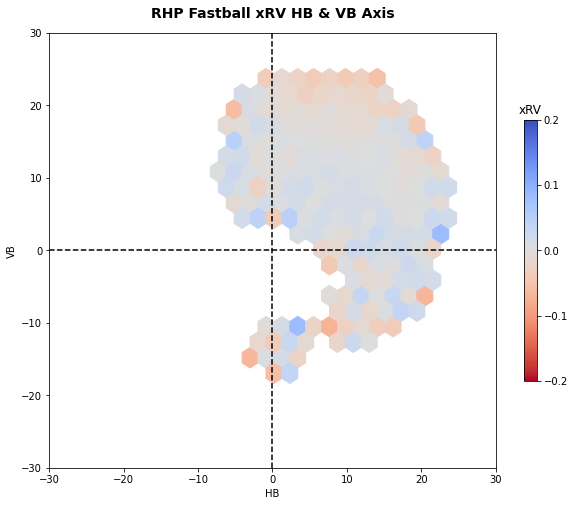

In [12]:
plt.figure(figsize = (10, 8))
plt.hexbin(rhp_fb['pfx_x'], rhp_fb['pfx_z'], C = rhp_fb['xRV'], cmap = 'coolwarm_r', 
           mincnt = 10, gridsize = 20)
cb = plt.colorbar(ticks = [-.2,-.1, 0, .1, .2], shrink = .6)
cb.ax.set_title('xRV'), plt.clim(-.2, .2)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('RHP Fastball xRV HB & VB Axis', fontsize = 14, fontweight = 'bold', pad = 15);

### LHP Fastball Break Plot by xRV

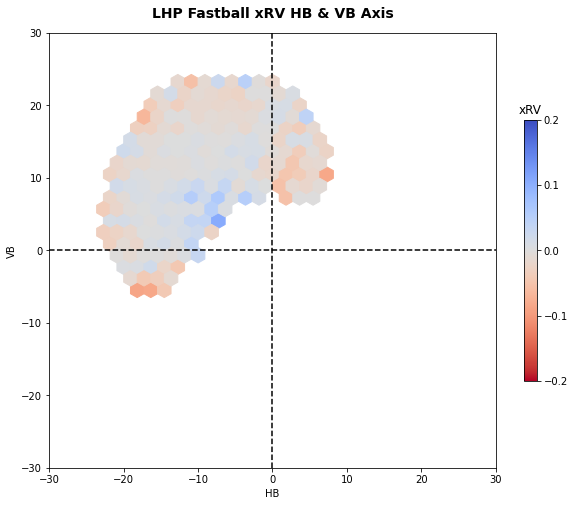

In [13]:
plt.figure(figsize = (10, 8))

plt.hexbin(lhp_fb['pfx_x'], lhp_fb['pfx_z'], C = lhp_fb['xRV'], cmap = 'coolwarm_r',
           mincnt = 10, gridsize = 20)
cb = plt.colorbar(ticks = [-.2,-.1, 0, .1, .2], shrink = .6)
cb.ax.set_title('xRV'), plt.clim(-.2, .2)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('LHP Fastball xRV HB & VB Axis', fontsize = 14, fontweight = 'bold', pad = 15);

# Breaking Ball Analysis

### Breaking Ball Metrics

In [14]:
good_rhp_bb = rhp_bb.groupby(['pitch_type', 'p_throws'], as_index = False, 
                                sort = False)['velo', 'pfx_x', 'pfx_z', 'xRV'].mean()
bb_r_pitches = rhp_bb.groupby(['pitch_type', 'p_throws'], as_index = False, sort = False)['n_pitches'].sum()
avg_rhp_bb = pd.merge(good_rhp_bb, bb_r_pitches, how = 'right', on = ['pitch_type', 'p_throws'])


good_lhp_bb = lhp_bb.groupby(['pitch_type', 'p_throws'], as_index = False, 
                                sort = False)['velo', 'pfx_x', 'pfx_z', 'xRV'].mean()
bb_l_pitches = lhp_bb.groupby(['pitch_type', 'p_throws'], as_index = False, sort = False)['n_pitches'].sum()
avg_lhp_bb = pd.merge(good_lhp_bb, bb_l_pitches, how = 'right', on = ['pitch_type', 'p_throws'])

bb_avg = pd.concat([avg_rhp_bb, avg_lhp_bb], ignore_index = True)
bb_avg.insert(2, 'n_pitches', bb_avg.pop('n_pitches'))
bb_avg = bb_avg.round(1)
bb_avg.head(8)

,pitch_type,p_throws,n_pitches,velo,pfx_x,pfx_z,xRV
0,SL,R,100754,84.9,-6.3,1.8,-0.0
1,CU,R,39992,79.2,-9.6,-9.3,-0.0
2,FC,R,31183,89.5,-3.0,7.9,-0.0
3,KC,R,11633,81.5,-8.3,-11.7,-0.0
4,SL,L,34780,83.9,5.8,1.5,-0.0
5,CU,L,18778,77.7,8.4,-7.5,-0.0
6,FC,L,16262,86.8,1.7,7.9,-0.0
7,KC,L,2039,78.9,5.0,-9.0,-0.0


### Above Average Breaking Ball Metrics

In [15]:
abv_rhp_bb = rhp_bb.loc[rhp_bb['xRV'] < -.05]
abv_lhp_bb = lhp_bb.loc[lhp_bb['xRV'] < -.05]

great_rhp_bb = abv_rhp_bb.groupby(['pitch_type', 'p_throws'], as_index = False, 
                                sort = False)['velo', 'pfx_x', 'pfx_z', 'xRV'].mean()
bb_r_pitches = abv_rhp_bb.groupby(['pitch_type', 'p_throws'], as_index = False, sort = False)['n_pitches'].sum()
abv_rhp_bb = pd.merge(great_rhp_bb, bb_r_pitches, how = 'right', on = ['pitch_type', 'p_throws'])


great_lhp_bb = abv_lhp_bb.groupby(['pitch_type', 'p_throws'], as_index = False, 
                                sort = False)['velo', 'pfx_x', 'pfx_z', 'xRV'].mean()
bb_l_pitches = abv_lhp_bb.groupby(['pitch_type', 'p_throws'], as_index = False, sort = False)['n_pitches'].sum()
abv_lhp_bb = pd.merge(great_lhp_bb, bb_l_pitches, how = 'right', on = ['pitch_type', 'p_throws'])

bb_abv = pd.concat([abv_rhp_bb, abv_lhp_bb], ignore_index = True)
bb_abv.insert(2, 'n_pitches', bb_abv.pop('n_pitches'))
bb_abv = bb_abv.round(1)
bb_abv.head(8)

,pitch_type,p_throws,n_pitches,velo,pfx_x,pfx_z,xRV
0,SL,R,26078,85.0,-6.9,1.6,-0.1
1,FC,R,6934,89.8,-3.3,7.8,-0.1
2,CU,R,9280,79.7,-10.3,-9.3,-0.1
3,KC,R,3030,82.1,-8.4,-11.4,-0.1
4,SL,L,9796,84.3,6.0,1.2,-0.1
5,CU,L,4981,78.2,8.9,-7.4,-0.1
6,FC,L,4097,86.7,2.1,7.4,-0.1
7,KC,L,409,79.6,4.9,-9.9,-0.1


### Below Average Breaking Ball Metrics

In [16]:
blw_rhp_bb = rhp_bb.loc[rhp_bb['xRV'] > .05]
blw_lhp_bb = lhp_bb.loc[lhp_bb['xRV'] > .05]

great_rhp_bb = blw_rhp_bb.groupby(['pitch_type', 'p_throws'], as_index = False, 
                                sort = False)['velo', 'pfx_x', 'pfx_z', 'xRV'].mean()
bb_r_pitches = blw_rhp_bb.groupby(['pitch_type', 'p_throws'], as_index = False, sort = False)['n_pitches'].sum()
blw_rhp_bb = pd.merge(great_rhp_bb, bb_r_pitches, how = 'right', on = ['pitch_type', 'p_throws'])


great_lhp_bb = blw_lhp_bb.groupby(['pitch_type', 'p_throws'], as_index = False, 
                                sort = False)['velo', 'pfx_x', 'pfx_z', 'xRV'].mean()
bb_l_pitches = blw_lhp_bb.groupby(['pitch_type', 'p_throws'], as_index = False, sort = False)['n_pitches'].sum()
blw_lhp_bb = pd.merge(great_lhp_bb, bb_l_pitches, how = 'right', on = ['pitch_type', 'p_throws'])

bb_blw = pd.concat([blw_rhp_bb, blw_lhp_bb], ignore_index = True)
bb_blw.insert(2, 'n_pitches', bb_blw.pop('n_pitches'))
bb_blw = bb_blw.round(1)
bb_blw.head(8)

,pitch_type,p_throws,n_pitches,velo,pfx_x,pfx_z,xRV
0,SL,R,11001,84.7,-5.8,1.9,0.2
1,CU,R,3996,78.8,-9.1,-9.5,0.2
2,KC,R,1129,81.0,-8.0,-11.9,0.2
3,FC,R,3948,89.7,-2.5,8.5,0.2
4,SL,L,3623,83.9,5.5,1.5,0.2
5,FC,L,2156,87.2,1.0,8.5,0.2
6,CU,L,1823,77.3,8.0,-7.8,0.2
7,KC,L,241,78.6,5.1,-8.9,0.2


### Top Breaking Balls by xRV

In [17]:
bb_rvtable.sort_values(by = 'xRV').head(10)

,player_name,p_throws,pitch_type,n_pitches,velo,pfx_x,pfx_z,release_pos_x,release_pos_z,release_extension,rv,xRV,RV/100,xRV/100
355,"Urías, Julio",L,CU,952,81.4,15.8,-0.9,-1.6,6.1,5.5,-38.7,-39.6,-4.1,-4.2
654,"Morton, Charlie",R,CU,1095,80.6,-16.6,-10.1,2.1,5.5,6.2,-39.3,-37.5,-3.6,-3.4
604,"McCullers Jr., Lance",R,SL,719,86.0,-13.7,4.6,1.7,5.1,6.0,-26.2,-29.7,-3.6,-4.1
123,"Burnes, Corbin",R,FC,1354,95.2,-4.2,11.2,0.9,5.9,6.4,-25.1,-27.9,-1.8,-2.1
293,"Rodón, Carlos",L,SL,603,85.8,8.2,-1.1,-2.3,6.5,6.0,-30.1,-27.3,-5.0,-4.5
357,"Valdez, Framber",L,CU,643,77.9,13.5,-15.3,-1.1,5.9,5.8,-26.3,-25.7,-4.1,-4.0
286,"Ray, Robbie",L,SL,964,88.6,1.0,7.2,-2.6,6.0,6.3,-31.3,-25.5,-3.2,-2.6
986,"Wainwright, Adam",R,CU,1027,73.5,-16.6,-14.7,1.2,6.4,6.4,-30.2,-25.4,-2.9,-2.5
659,"Musgrove, Joe",R,SL,815,84.1,-14.0,-1.6,1.4,6.4,5.9,-30.3,-25.3,-3.7,-3.1
212,"McClanahan, Shane",L,SL,674,89.2,3.8,2.0,-0.8,6.2,6.8,-22.5,-25.1,-3.3,-3.7


### RHP Breaking Ball Break Plot by xRV

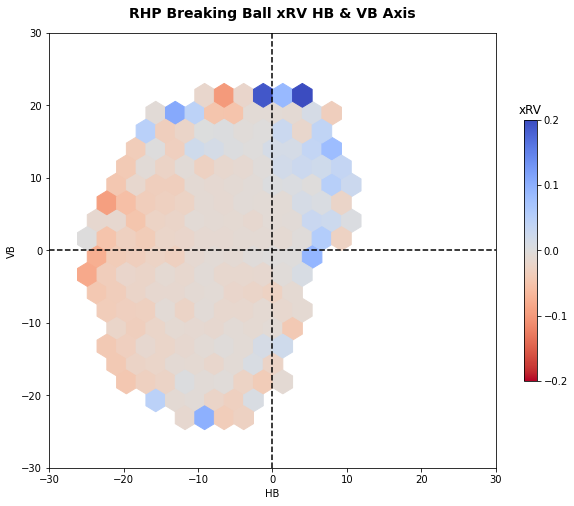

In [18]:
plt.figure(figsize = (10, 8))

plt.hexbin(rhp_bb['pfx_x'], rhp_bb['pfx_z'], C = rhp_bb['xRV'],cmap='coolwarm_r',
           mincnt = 10, gridsize = 20)
cb = plt.colorbar(ticks = [-.2,-.1, 0, .1, .2], shrink = .6)
cb.ax.set_title('xRV'), plt.clim(-.2, .2)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('RHP Breaking Ball xRV HB & VB Axis', fontsize = 14, fontweight = 'bold', pad = 15);

### LHP Breaking Ball Break Plot by xRV

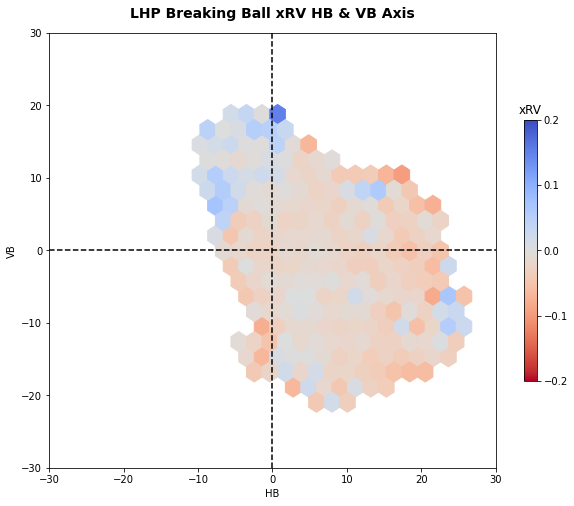

In [19]:
plt.figure(figsize = (10, 8))

plt.hexbin(lhp_bb['pfx_x'], lhp_bb['pfx_z'], C = lhp_bb['xRV'],cmap='coolwarm_r', 
           mincnt = 5, gridsize = 20)
cb = plt.colorbar(ticks = [-.2,-.1, 0, .1, .2], shrink = .6)
cb.ax.set_title('xRV'), plt.clim(-.2, .2)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('LHP Breaking Ball xRV HB & VB Axis', fontsize = 14, fontweight = 'bold', pad = 15);

# Off-Speed Analysis

### Off-Speed Metrics

In [20]:
good_rhp_os = rhp_os.groupby(['pitch_type', 'p_throws'], as_index = False, 
                                sort = False)['velo', 'pfx_x', 'pfx_z', 'xRV'].mean()
os_r_pitches = rhp_os.groupby(['pitch_type', 'p_throws'], as_index = False, sort = False)['n_pitches'].sum()
avg_rhp_os = pd.merge(good_rhp_os, os_r_pitches, how = 'right', on = ['pitch_type', 'p_throws'])


good_lhp_os = lhp_os.groupby(['pitch_type', 'p_throws'], as_index = False, 
                                sort = False)['velo', 'pfx_x', 'pfx_z', 'xRV'].mean()
os_l_pitches = lhp_os.groupby(['pitch_type', 'p_throws'], as_index = False, sort = False)['n_pitches'].sum()
avg_lhp_os = pd.merge(good_lhp_os, os_l_pitches, how = 'right', on = ['pitch_type', 'p_throws'])

os_avg = pd.concat([avg_rhp_os, avg_lhp_os], ignore_index = True)
os_avg.insert(2, 'n_pitches', os_avg.pop('n_pitches'))
os_avg = os_avg.round(1)
os_avg.head()

,pitch_type,p_throws,n_pitches,velo,pfx_x,pfx_z,xRV
0,CH,R,50661,85.5,13.8,6.3,-0.0
1,FS,R,10239,85.8,10.7,3.9,-0.0
2,CH,L,29677,83.6,-13.9,7.8,-0.0
3,FS,L,603,83.8,-8.7,4.0,-0.0


### Above Average Off-Speed Metrics

In [21]:
abv_rhp_os = rhp_os.loc[rhp_os['xRV'] < -.05]
abv_lhp_os = lhp_os.loc[lhp_os['xRV'] < -.05]

great_rhp_os = abv_rhp_os.groupby(['pitch_type', 'p_throws'], as_index = False, 
                                sort = False)['velo', 'pfx_x', 'pfx_z', 'xRV'].mean()
os_r_pitches = abv_rhp_os.groupby(['pitch_type', 'p_throws'], as_index = False, sort = False)['n_pitches'].sum()
abv_rhp_os = pd.merge(great_rhp_os, os_r_pitches, how = 'right', on = ['pitch_type', 'p_throws'])


great_lhp_os = abv_lhp_os.groupby(['pitch_type', 'p_throws'], as_index = False, 
                                sort = False)['velo', 'pfx_x', 'pfx_z', 'xRV'].mean()
os_l_pitches = abv_lhp_os.groupby(['pitch_type', 'p_throws'], as_index = False, sort = False)['n_pitches'].sum()
abv_lhp_os = pd.merge(great_lhp_os, os_l_pitches, how = 'right', on = ['pitch_type', 'p_throws'])

os_abv = pd.concat([abv_rhp_os, abv_lhp_os], ignore_index = True)
os_abv.insert(2, 'n_pitches', os_abv.pop('n_pitches'))
os_abv = os_abv.round(1)
os_abv.head()

,pitch_type,p_throws,n_pitches,velo,pfx_x,pfx_z,xRV
0,CH,R,12833,85.5,13.8,6.0,-0.1
1,FS,R,3200,85.8,10.3,3.6,-0.1
2,CH,L,7727,83.5,-14.0,7.5,-0.1
3,FS,L,181,84.5,-8.0,2.6,-0.2


### Below Average Off-Speed Metrics

In [22]:
blw_rhp_os = rhp_os.loc[rhp_os['xRV'] > .05]
blw_lhp_os = lhp_os.loc[lhp_os['xRV'] > .05]

great_rhp_os = blw_rhp_os.groupby(['pitch_type', 'p_throws'], as_index = False, 
                                sort = False)['velo', 'pfx_x', 'pfx_z', 'xRV'].mean()
os_r_pitches = blw_rhp_os.groupby(['pitch_type', 'p_throws'], as_index = False, sort = False)['n_pitches'].sum()
blw_rhp_os = pd.merge(great_rhp_os, os_r_pitches, how = 'right', on = ['pitch_type', 'p_throws'])


great_lhp_os = blw_lhp_os.groupby(['pitch_type', 'p_throws'], as_index = False, 
                                sort = False)['velo', 'pfx_x', 'pfx_z', 'xRV'].mean()
os_l_pitches = blw_lhp_os.groupby(['pitch_type', 'p_throws'], as_index = False, sort = False)['n_pitches'].sum()
blw_lhp_os = pd.merge(great_lhp_os, os_l_pitches, how = 'right', on = ['pitch_type', 'p_throws'])

os_blw = pd.concat([blw_rhp_os, blw_lhp_os], ignore_index = True)
os_blw.insert(2, 'n_pitches', os_blw.pop('n_pitches'))
os_blw = os_blw.round(1)
os_blw.head()

,pitch_type,p_throws,n_pitches,velo,pfx_x,pfx_z,xRV
0,CH,R,6771,85.5,13.5,6.6,0.2
1,FS,R,1131,86.0,10.1,4.2,0.2
2,CH,L,4045,83.6,-13.6,7.9,0.2
3,FS,L,68,83.5,-9.7,6.0,0.2


### Top Off-Speeds by xRV

In [23]:
os_rvtable.sort_values(by = 'xRV').head(10)

,player_name,p_throws,pitch_type,n_pitches,velo,pfx_x,pfx_z,release_pos_x,release_pos_z,release_extension,rv,xRV,RV/100,xRV/100
176,"Gausman, Kevin",R,FS,1044,83.6,12.3,2.2,2.7,5.9,6.5,-50.0,-43.7,-4.8,-4.2
76,"Castillo, Luis",R,CH,952,88.3,16.8,0.9,2.8,5.0,5.6,-28.1,-28.5,-3.0,-3.0
322,"Montas, Frankie",R,FS,677,87.5,11.5,3.8,1.2,6.2,6.0,-27.6,-28.3,-4.1,-4.2
98,"Manaea, Sean",L,CH,723,84.5,-12.2,6.7,-3.2,5.9,7.2,-21.4,-26.2,-3.0,-3.6
101,"Matz, Steven",L,CH,598,85.1,-15.9,3.3,-1.9,5.7,6.5,-19.9,-24.8,-3.3,-4.2
504,"Williams, Devin",R,CH,621,83.7,17.0,-4.2,2.3,5.4,6.8,-20.7,-22.5,-3.3,-3.6
360,"Peralta, Wily",R,FS,352,81.3,10.2,6.7,1.1,6.6,5.8,-23.4,-22.3,-6.6,-6.3
343,"Ohtani, Shohei",R,FS,366,88.1,4.9,2.4,1.8,6.2,6.8,-23.5,-22.0,-6.4,-6.0
183,"Giolito, Lucas",R,CH,940,81.5,10.2,12.9,1.6,6.4,6.7,-22.0,-20.9,-2.3,-2.2
152,"Flexen, Chris",R,CH,431,82.7,12.2,9.6,0.8,6.7,6.0,-16.5,-19.6,-3.8,-4.6


### RHP Off-Speed Break Plot by xRV

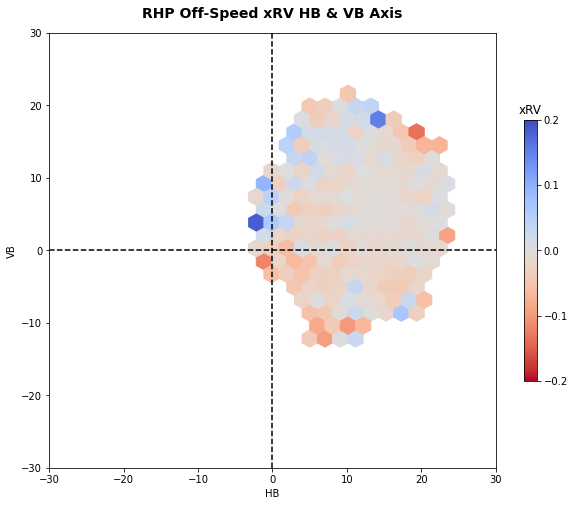

In [24]:
plt.figure(figsize = (10, 8))

plt.hexbin(rhp_os['pfx_x'], rhp_os['pfx_z'], C = rhp_os['xRV'], cmap = 'coolwarm_r',
           mincnt = 5, gridsize = 20)
cb = plt.colorbar(ticks = [-.2,-.1, 0, .1, .2], shrink = .6)
cb.ax.set_title('xRV'), plt.clim(-.2, .2)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('RHP Off-Speed xRV HB & VB Axis', fontsize = 14, fontweight = 'bold', pad = 15);

### LHP Off-Speed Break Plot by xRV

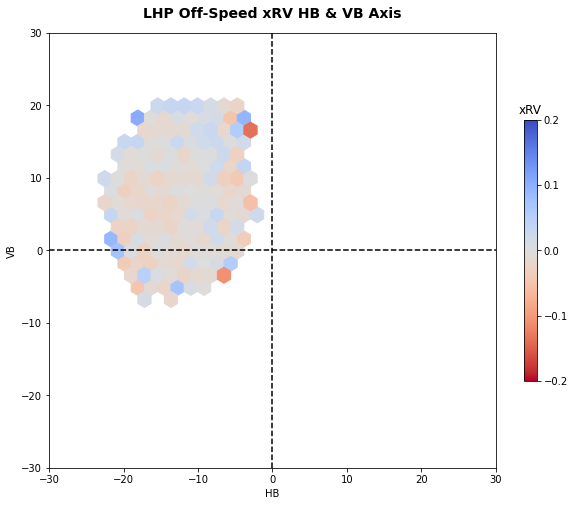

In [25]:
plt.figure(figsize = (10, 8))

plt.hexbin(lhp_os['pfx_x'], lhp_os['pfx_z'], C = lhp_os['xRV'], cmap = 'coolwarm_r',
           mincnt = 5, gridsize = 20)
cb = plt.colorbar(ticks = [-.2,-.1, 0, .1, .2], shrink = .6)
cb.ax.set_title('xRV'), plt.clim(-.2, .2)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('LHP Off-Speed xRV HB & VB Axis', fontsize = 14, fontweight = 'bold', pad = 15);